In [7]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import random
import numpy as np
import pylab
import quandl
quandl.ApiConfig.api_key = "32peB6ExRM7Lihbpsdsd"
import seaborn as sns
sns.set()
%matplotlib inline
#textblob to apply sentiment analysis 
from textblob import TextBlob
import preprocessor as p

# Getting Stocks

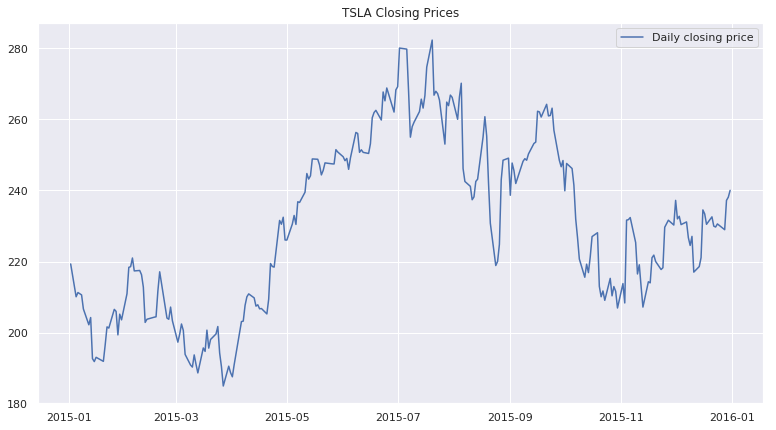

In [8]:
from pandas.plotting import register_matplotlib_converters
start = datetime.datetime(2015,1,1) # Beginning of period 
end = datetime.datetime(2016,1,1) # End of period 
stock = "TSLA" # some stock label we are interested in
data = quandl.get("WIKI/" + stock, start_date=start, end_date=end)
pylab.rcParams['figure.figsize'] = (13, 7)
plt.title(stock + " Closing Prices")
plt.plot(data["Close"],label="Daily closing price") # plot daily closing prices 
plt.legend()
plt.show()

In [9]:
data.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2015-12-24,230.56,231.880,228.2800,230.57,710277.0,0.0,1.0,230.56,231.880,228.2800,230.57,710277.0
2015-12-28,231.49,231.980,225.5400,228.95,1901304.0,0.0,1.0,231.49,231.980,225.5400,228.95,1901304.0
2015-12-29,230.06,237.720,229.5470,237.19,2406290.0,0.0,1.0,230.06,237.720,229.5470,237.19,2406290.0
2015-12-30,236.60,243.634,235.6707,238.09,3697921.0,0.0,1.0,236.60,243.634,235.6707,238.09,3697921.0
2015-12-31,238.51,243.450,238.3700,240.01,2715038.0,0.0,1.0,238.51,243.450,238.3700,240.01,2715038.0


In [10]:
data['Date'] = data.index
new_data = pd.DataFrame(index=range(0,len(data)),columns=['Date', 'Close'])
for i in range(0,len(data)):
     new_data['Date'][i] = data['Date'][i]
     new_data['Close'][i] = data['Close'][i]

      
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)    
len(new_data)

252

In [13]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#splitting into train and validation
#creating train and test sets
dataset = new_data.values

train = dataset[0:150]#using the first 150 days as a train set
valid = dataset[150:]


Using TensorFlow backend.


In [14]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(30,len(train)):
    x_train.append(scaled_data[i-30:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

/Users/neutrino/Library/Python/3.7/lib/python/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [15]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 6s - loss: 0.0267


In [21]:
#predicting 246 values, using past 30 from the train data
inputs = new_data[len(new_data) - len(valid) - 30:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(30,inputs.shape[0]):
    X_test.append(inputs[i-30:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

## Results

In [22]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

12.035386282166616

/Users/neutrino/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


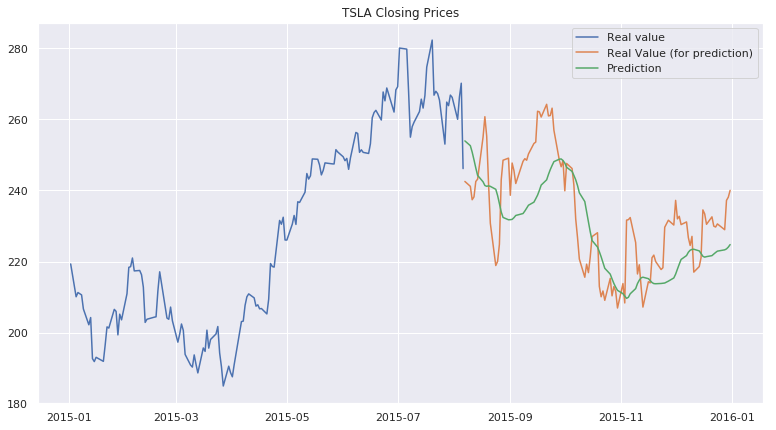

In [46]:
valid['Predictions'] = closing_price
plt.plot(train['Close'], label = "Real value");
plt.plot(valid['Close'],label='Real Value (for prediction)');
plt.plot(valid['Predictions'],label="Prediction");
plt.title(stock + " Closing Prices")
plt.legend()